In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

from numpy import array as arr

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset, DataLoader, Dataset, TensorDataset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [2]:
url_train = 'https://raw.githubusercontent.com/JERRITE/DeepLearning-Windenergy-Project2022/main/data/train.csv'
url_windforecasts_wf1 = 'https://raw.githubusercontent.com/JERRITE/DeepLearning-Windenergy-Project2022/main/data/windforecasts_wf1.csv'
df_train = pd.read_csv(url_train)
df_plant_1 = pd.read_csv(url_windforecasts_wf1)

## examining the data

In [5]:
df_working = df_plant_1
df_working["date"] = pd.to_datetime(df_working["date"], format='%Y%m%d%H')
df_working = df_working.set_index("date")
df_working = df_working.rename(columns = {"hors": "hours"}).rename_axis(None)

In [6]:
END_DATE = pd.to_datetime("2011-01-01-00")
HOURS_OF_INTEREST = np.arange(1, 13, 1)
data_range_included_explanatory_variables = pd.date_range(
    start = df_working.index[0], end = END_DATE, freq='12h')
df_working = df_working \
    .loc[df_working.index.isin(data_range_included_explanatory_variables)]

In [7]:
x_toy = np.hstack((np.repeat(1, 48), np.repeat(2, 48), np.repeat(3, 48), np.repeat(4, 48)))
addition = 1
index_forecasted_weather = np.hstack(np.repeat(x_toy[None, :], df_working.shape[0] / (48*4) + addition, axis = 0))
index_forecasted_weather = index_forecasted_weather[0: df_working.shape[0]]
df_working.loc[:, "index_forecasted_weather"] = index_forecasted_weather

In [8]:
index_to_be_incremented = df_working.index
new_index = list()
index_shape = index_to_be_incremented.shape[0]
for addition, i in zip(df_working.hours.to_numpy(), range(index_shape)):
    new_index.append(index_to_be_incremented[i] + pd.Timedelta(hours = addition))
new_index = pd.to_datetime(new_index)
df_working.index = new_index

In [9]:
df_working_ws = df_working.loc[:, ["hours", "ws", "index_forecasted_weather"]]
df_working_wd = df_working.loc[:, ["hours", "wd", "index_forecasted_weather"]]

pivoted_ws = df_working_ws.reset_index().pivot(index="index", columns="index_forecasted_weather",
                              values="ws").rename(columns = {1: "ws_1", 2: "ws_2", 3: "ws_3", 4: "ws_4"})
pivoted_wd = df_working_wd.reset_index().pivot(index="index", columns="index_forecasted_weather",
                              values="wd").rename(columns = {1: "wd_1", 2: "wd_2", 3: "wd_3", 4: "wd_4"})

result = pivoted_ws.merge(pivoted_wd, how='inner', on='index').rename_axis(None, axis = 1).rename_axis(None)\
    .assign(
        wd_sin_1 = lambda df: np.sin(df.wd_1 * (2*np.pi / 360)),
        wd_cos_1 = lambda df: np.cos(df.wd_1 * (2*np.pi / 360)),
        wd_sin_2 = lambda df: np.sin(df.wd_2 * (2*np.pi / 360)),
        wd_cos_2 = lambda df: np.cos(df.wd_2 * (2*np.pi / 360)),
        wd_sin_3 = lambda df: np.sin(df.wd_3 * (2*np.pi / 360)),
        wd_cos_3 = lambda df: np.cos(df.wd_3 * (2*np.pi / 360)),
        wd_sin_4 = lambda df: np.sin(df.wd_4 * (2*np.pi / 360)),
        wd_cos_4 = lambda df: np.cos(df.wd_4 * (2*np.pi / 360)),
    ).drop(columns = ["wd_1", "wd_2", "wd_3", "wd_4"])
# result.head()

## Adding the observed power to the result data frame

In [10]:
df_working_train = df_train
df_working_train["date"] = pd.to_datetime(df_working_train["date"], format='%Y%m%d%H')
df_working_train = df_working_train.set_index("date")
df_working_train = df_working_train.rename_axis(None)
df_working_train.shape

(18757, 7)

In [11]:
END_DATE_TRAIN = pd.to_datetime("2011-01-01-00")
data_range_included_response_variables = pd.date_range(
    start = df_working_train.index[0], end = END_DATE_TRAIN, freq='1h')
df_train_processed = df_working_train\
    .loc[df_working_train.index.isin(data_range_included_response_variables)]
df_train_processed.drop(df_train_processed.head(1).index, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Exploratory Data Analysis

In [14]:
## PLOTTING WIND SPEED FOR DIFFERENT PREDICTIONS
start_1 = 0
start_2 = 12
start_3 = 24
start_4 = 36

# TO DO: ADD JUMPS AUTOMIATICALLY
# HOWEVER, THE POINT IS CLEAR
# xcoords = [0.22058956, 0.33088437, 2.20589566]
# for xc in xcoords:
#     plt.axvline(x=xc)

PERIOD = 48
def print_stuff(input):
    start = input
    end  = start + 2
    result_plotting = result.iloc[PERIOD*start: PERIOD*end, :]
    # sns.set_theme(style=None)
    colors = ["red", "green", "blue", "orange"]

    fix, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6))
    ax1.plot(result_plotting.index, result_plotting.ws_1, label = "ws_1", color = colors[0])
    ax1.plot(result_plotting.index, result_plotting.ws_2, label = "ws_2", color = colors[1])
    ax1.plot(result_plotting.index, result_plotting.ws_3, label = "ws_3", color = colors[2])
    ax1.plot(result_plotting.index, result_plotting.ws_4, label = "ws_4", color = colors[3])
    ax1.legend()
    ax1.grid(True)
    ax1.tick_params(axis = "x", labelrotation=45)
    # for i in range():
    # ax1.axvline(x = result.index[start_1], color = colors[0])
    # ax1.axvline(x = result.index[start_2], color = colors[1])
    # ax1.axvline(x = result.index[start_3], color = colors[2])
    # ax1.axvline(x = result.index[start_4], color = colors[3])

    ax2.plot(result_plotting.index, result_plotting.wd_sin_1, label = "wd_sin_1", color = colors[0])
    ax2.plot(result_plotting.index, result_plotting.wd_sin_2, label = "wd_sin_2", color = colors[1])
    ax2.plot(result_plotting.index, result_plotting.wd_sin_3, label = "wd_sin_3", color = colors[2])
    ax2.plot(result_plotting.index, result_plotting.wd_sin_4, label = "wd_sin_4", color = colors[3])
    ax2.legend()
    ax2.grid(True)
    ax2.tick_params(axis = "x", labelrotation=45)

    ax3.plot(result_plotting.index, result_plotting.wd_cos_1, label = "wd_cos_1", color = colors[0])
    ax3.plot(result_plotting.index, result_plotting.wd_cos_2, label = "wd_cos_2", color = colors[1])
    ax3.plot(result_plotting.index, result_plotting.wd_cos_3, label = "wd_cos_3", color = colors[2])
    ax3.plot(result_plotting.index, result_plotting.wd_cos_4, label = "wd_cos_4", color = colors[3])
    ax3.legend()
    ax3.grid(True)
    ax3.tick_params(axis = "x", labelrotation=45)
    plt.show();

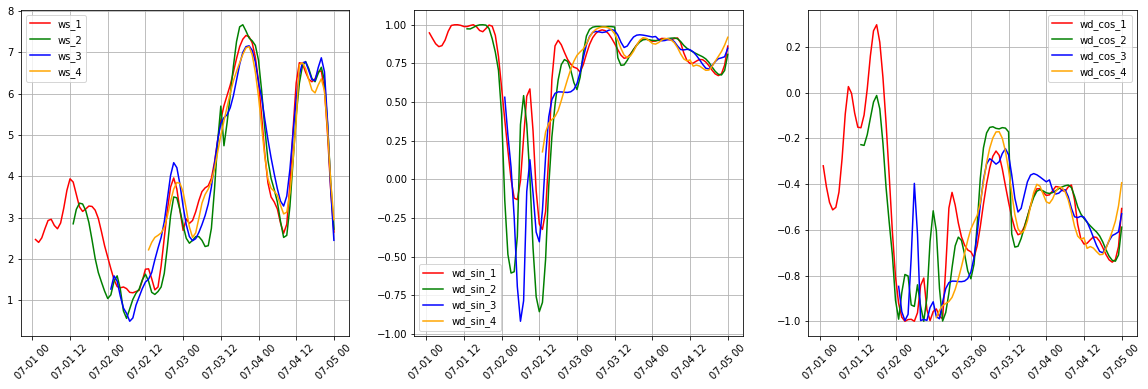

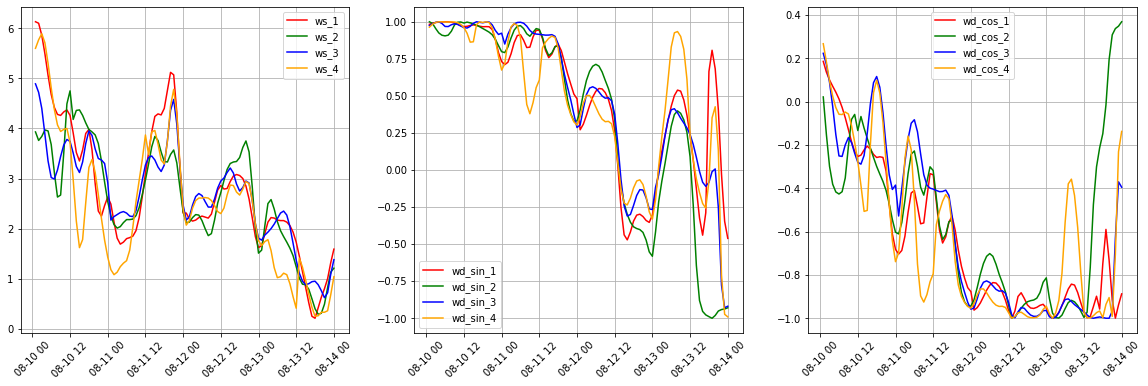

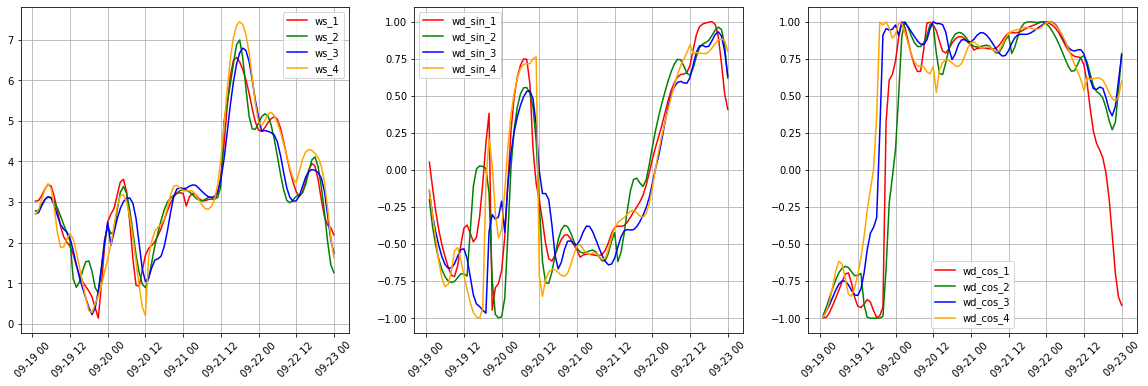

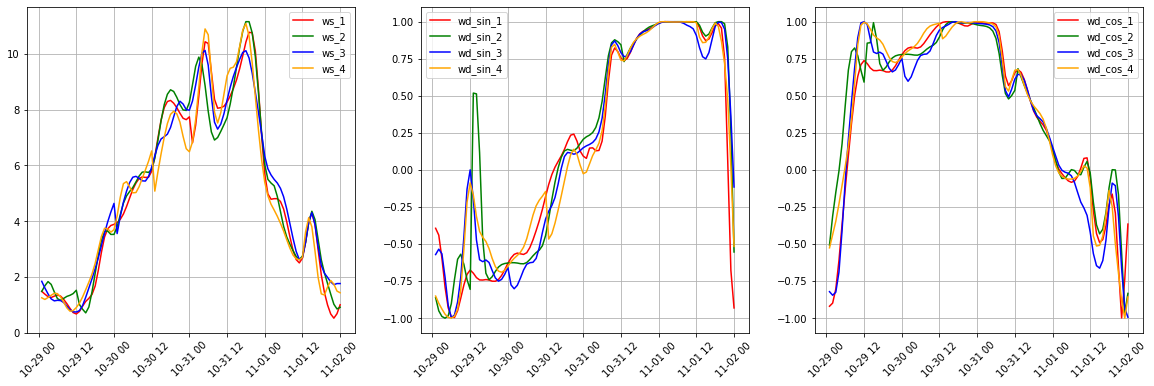

In [15]:
for i in range(0, 4, 1):
    print_stuff(i*20)

In [20]:
from scipy import stats
import statsmodels.api as sm_api
# xt, lambda_boxcox = stats.boxcox(df_1_processed.wp1)

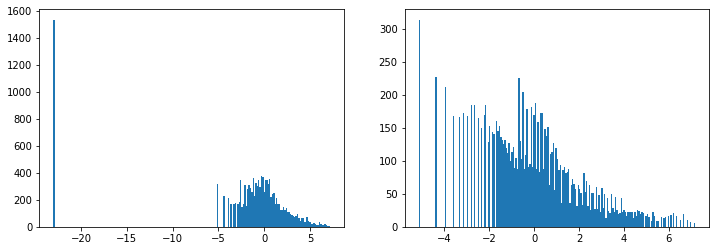

In [21]:
def transformation(lambda_, y):
    epsilon = 1e-10
    y = np.where(y > 0, y, epsilon)
    return np.log((y**lambda_) / (1 - y**lambda_)) / lambda_

y_transformed = transformation(0.5, df_train_processed.wp1)
y_transformed_fake = transformation(0.5, df_train_processed.wp1[df_train_processed.wp1 > 0])

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].hist(y_transformed, bins = 200);
ax[1].hist(y_transformed_fake, bins = 200);

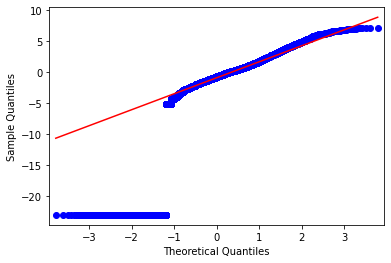

In [23]:
sm_api.qqplot(transformation(0.5, df_train_processed.wp1), line = "q");

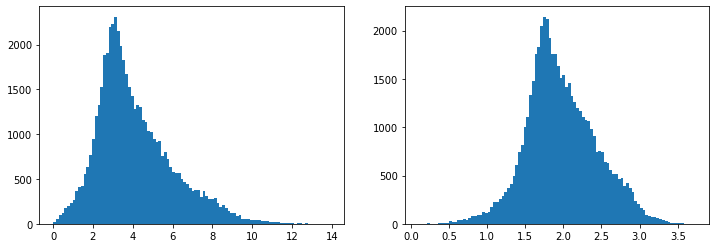

In [43]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].hist(df_working.ws, bins = 100);
ax[1].hist(np.sqrt(df_working.ws), bins = 100);

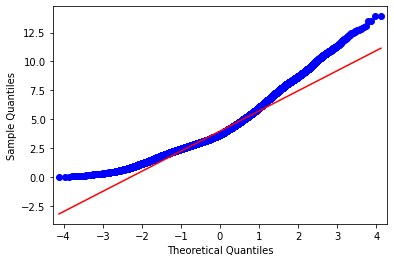

In [44]:
sm_api.qqplot(df_working.ws, line = "q");

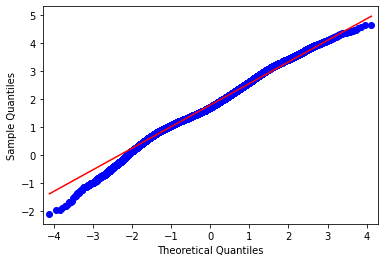

In [45]:
xt, lambda_boxcox = stats.boxcox(df_working.ws)
sm_api.qqplot(xt, line = "q");

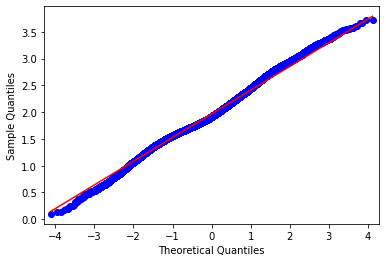

In [46]:
sm_api.qqplot(np.sqrt(df_working.ws), line = "q");

## Furhter preprocessing, feature creation

In [28]:
df_working["wp1"] = df_train_processed.loc[:, "wp1"]

result = list()
unique_index = np.unique(df_working.index)
for index_elem in unique_index:
    array_toy = df_working.loc[df_working.index == index_elem].wp1.values
    result.append(np.unique(array_toy).shape[0] == 1)
result = np.array(result)
assert np.all(result == True)

In [29]:
df_working = df_working.assign(
        wd_sin = lambda df: np.sin(df.wd * (2*np.pi / 360)),
        wd_cos = lambda df: np.cos(df.wd * (2*np.pi / 360)),
        month_sin = lambda df: np.sin((df.index.month - 1) * (2*np.pi / 12)),
        month_cos = lambda df: np.cos((df.index.month - 1) * (2*np.pi / 12)),
        hour_sin = lambda df: np.sin((df.index.hour) * (2*np.pi / 24)),
        hour_cos = lambda df: np.cos((df.index.hour) * (2*np.pi / 24))
    ).drop(columns = ["wd"])

In [30]:
df_working.head()

,hours,u,v,ws,index_forecasted_weather,wp1,wd_sin,wd_cos,month_sin,month_cos,hour_sin,hour_cos
2009-07-01 01:00:00,1,2.34,-0.79,2.47,1,0.085,0.947322,-0.320282,1.224647e-16,-1.0,0.258819,0.965926
2009-07-01 02:00:00,2,2.18,-0.99,2.40,1,0.020,0.911331,-0.411673,1.224647e-16,-1.0,0.500000,0.866025
2009-07-01 03:00:00,3,2.20,-1.21,2.51,1,0.060,0.877062,-0.480377,1.224647e-16,-1.0,0.707107,0.707107
2009-07-01 04:00:00,4,2.35,-1.40,2.73,1,0.045,0.858423,-0.512942,1.224647e-16,-1.0,0.866025,0.500000
2009-07-01 05:00:00,5,2.53,-1.47,2.93,1,0.035,0.864889,-0.501964,1.224647e-16,-1.0,0.965926,0.258819


In [31]:
df_working_updated = df_working[df_working.index.isin(data_range_included_response_variables)]
df_working_updated.loc[df_working_updated.index == END_DATE_TRAIN]

,hours,u,v,ws,index_forecasted_weather,wp1,wd_sin,wd_cos,month_sin,month_cos,hour_sin,hour_cos
2011-01-01,48,3.20,4.72,5.70,3,0.551,0.561650,0.827375,0.0,1.0,0.0,1.0
2011-01-01,36,3.16,4.10,5.18,4,0.551,0.610698,0.791863,0.0,1.0,0.0,1.0
2011-01-01,24,3.61,4.67,5.90,1,0.551,0.611251,0.791437,0.0,1.0,0.0,1.0
2011-01-01,12,3.46,4.87,5.98,2,0.551,0.579281,0.815128,0.0,1.0,0.0,1.0


In [32]:
FILTER_UNTIL = df_working_updated.reset_index().loc[df_working_updated.index == END_DATE_TRAIN].index[0]
df_working_updated = df_working_updated.iloc[0:FILTER_UNTIL + 1, :]

list_toy = df_working_updated.columns.values.tolist()
list_always = ['wp1', 'index_forecasted_weather']
item_list = [item for item in list_toy if item not in list_always]
df_working_updated = df_working_updated.filter([*item_list, *list_always])
print(df_working_updated.shape[0] / 48)

1095.0


### Transformations

In [33]:
ws_transformed = np.sqrt(df_working_updated.ws)
df_working_updated["ws"] = ws_transformed

mean_ws = np.mean(df_working_updated["ws"]); std_ws = np.std(df_working_updated["ws"])
mean_wd_sin = np.mean(df_working_updated["wd_sin"]); std_wd_sin = np.std(df_working_updated["wd_sin"])
mean_wd_cos = np.mean(df_working_updated["wd_cos"]); std_wd_cos = np.std(df_working_updated["wd_cos"])
mean_u = np.mean(df_working_updated["u"]); std_u = np.std(df_working_updated["u"])
mean_v = np.mean(df_working_updated["v"]); std_v = np.std(df_working_updated["v"])
mean_month_sin = np.mean(df_working_updated["month_sin"]); std_month_sin = np.std(df_working_updated["month_sin"])
mean_month_cos = np.mean(df_working_updated["month_cos"]); std_month_cos = np.std(df_working_updated["month_cos"])
mean_hour_sin = np.mean(df_working_updated["hour_sin"]); std_hour_sin = np.std(df_working_updated["hour_sin"])
mean_hour_cos = np.mean(df_working_updated["hour_cos"]); std_hour_cos = np.std(df_working_updated["hour_cos"])

In [34]:
df_working_updated["ws"] = (df_working_updated["ws"] - mean_ws) / std_ws
df_working_updated["wd_sin"] = (df_working_updated["wd_sin"] - mean_wd_sin) / std_wd_sin
df_working_updated["wd_cos"] = (df_working_updated["wd_cos"] - mean_wd_cos) / std_wd_cos
df_working_updated["u"] = (df_working_updated["u"] - mean_u) / std_u
df_working_updated["v"] = (df_working_updated["v"] - mean_v) / std_v
df_working_updated["month_sin"] = (df_working_updated["month_sin"] - mean_month_sin) / std_month_sin
df_working_updated["month_cos"] = (df_working_updated["month_cos"] - mean_month_cos) / std_month_cos
df_working_updated["hour_sin"] = (df_working_updated["hour_sin"] - mean_hour_sin) / std_hour_sin
df_working_updated["hour_cos"] = (df_working_updated["hour_cos"] - mean_hour_cos) / std_hour_cos

In [35]:
HOURS_OF_INTEREST = np.arange(1, 13, 1)
df_working_sliding_window = df_working_updated \
    .loc[lambda df: df.hours.isin(HOURS_OF_INTEREST)]
    
# it's for the sliding window so it doesn't have to be to the very end
print(df_working_sliding_window.index.is_unique)
df_working_sliding_window.tail()

True


,hours,u,v,ws,wd_sin,wd_cos,month_sin,month_cos,hour_sin,hour_cos,wp1,index_forecasted_weather
2010-12-30 08:00:00,8,0.207391,1.538628,0.482800,0.203273,1.410349,-0.429685,1.31365,1.224745e+00,-0.707107,0.015,3
2010-12-30 09:00:00,9,0.062905,1.618082,0.487731,0.062043,1.475259,-0.429685,1.31365,1.000000e+00,-1.000000,0.020,3
2010-12-30 10:00:00,10,-0.045460,1.576628,0.378044,-0.020466,1.505531,-0.429685,1.31365,7.071068e-01,-1.224745,0.045,3
2010-12-30 11:00:00,11,-0.098001,1.493720,0.234575,-0.042371,1.512685,-0.429685,1.31365,3.660254e-01,-1.366025,0.045,3
2010-12-30 12:00:00,12,-0.061879,1.476447,0.229367,-0.005424,1.500408,-0.429685,1.31365,1.602146e-16,-1.414214,0.065,3


In [ ]:
# SAVING DATAFRAMES
df_working_updated.to_csv(drive_path + 'df_plant_1_processed_final_changed.csv')
df_working_sliding_window.to_csv(drive_path + 'df_plant_1_processed_sliding_window_changed.csv')